Train: 1750, Val: 375, Test: 375

### Training Model [5]
Epoch 10/100 — Train Loss: 0.7149, Val Loss: 0.6962
Epoch 20/100 — Train Loss: 0.6209, Val Loss: 0.5964
Epoch 30/100 — Train Loss: 0.5366, Val Loss: 0.5059
Epoch 40/100 — Train Loss: 0.4474, Val Loss: 0.4129
Epoch 50/100 — Train Loss: 0.3631, Val Loss: 0.3283
Epoch 60/100 — Train Loss: 0.2992, Val Loss: 0.2677
Epoch 70/100 — Train Loss: 0.2582, Val Loss: 0.2322
Epoch 80/100 — Train Loss: 0.2312, Val Loss: 0.2105
Epoch 90/100 — Train Loss: 0.2083, Val Loss: 0.1906
Epoch 100/100 — Train Loss: 0.1864, Val Loss: 0.1712

--- Model [5] Evaluation ---
Confusion Matrix:
[[324   3]
 [ 28  20]]
Accuracy:  91.73%
Precision: 0.8696
Recall:    0.4167
F1 Score:  0.5634


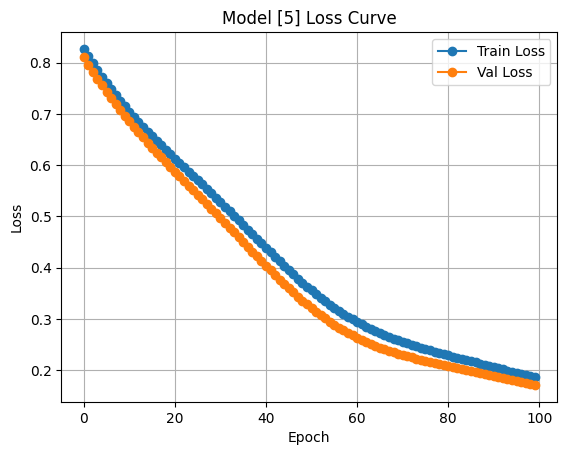


### Training Model [10, 8]
Epoch 10/100 — Train Loss: 0.6660, Val Loss: 0.6453
Epoch 20/100 — Train Loss: 0.4413, Val Loss: 0.4005
Epoch 30/100 — Train Loss: 0.2934, Val Loss: 0.2552
Epoch 40/100 — Train Loss: 0.2416, Val Loss: 0.2167
Epoch 50/100 — Train Loss: 0.2086, Val Loss: 0.1930
Epoch 60/100 — Train Loss: 0.1824, Val Loss: 0.1680
Epoch 70/100 — Train Loss: 0.1677, Val Loss: 0.1557
Epoch 80/100 — Train Loss: 0.1578, Val Loss: 0.1489
Epoch 90/100 — Train Loss: 0.1497, Val Loss: 0.1432
Epoch 100/100 — Train Loss: 0.1429, Val Loss: 0.1370

--- Model [10, 8] Evaluation ---
Confusion Matrix:
[[325   2]
 [ 18  30]]
Accuracy:  94.67%
Precision: 0.9375
Recall:    0.6250
F1 Score:  0.7500


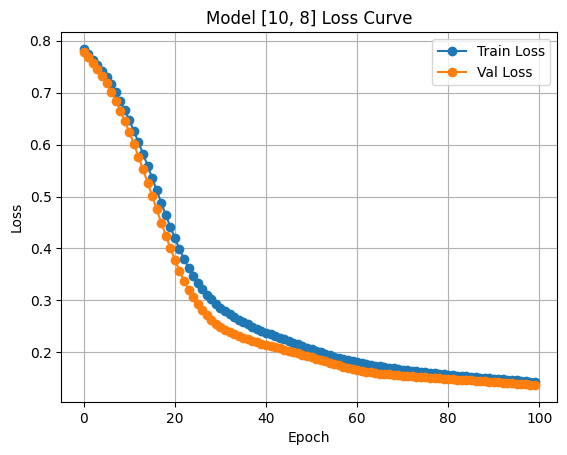


### Training Model [20, 10, 5]
Epoch 10/100 — Train Loss: 0.4708, Val Loss: 0.4111
Epoch 20/100 — Train Loss: 0.2631, Val Loss: 0.2222
Epoch 30/100 — Train Loss: 0.1936, Val Loss: 0.1726
Epoch 40/100 — Train Loss: 0.1686, Val Loss: 0.1544
Epoch 50/100 — Train Loss: 0.1442, Val Loss: 0.1287
Epoch 60/100 — Train Loss: 0.1291, Val Loss: 0.1136
Epoch 70/100 — Train Loss: 0.1171, Val Loss: 0.1052
Epoch 80/100 — Train Loss: 0.1032, Val Loss: 0.0938
Epoch 90/100 — Train Loss: 0.0864, Val Loss: 0.0802
Epoch 100/100 — Train Loss: 0.0686, Val Loss: 0.0667

--- Model [20, 10, 5] Evaluation ---
Confusion Matrix:
[[324   3]
 [  7  41]]
Accuracy:  97.33%
Precision: 0.9318
Recall:    0.8542
F1 Score:  0.8913


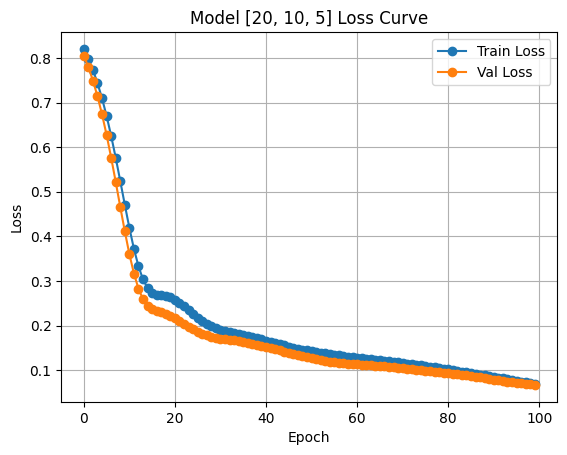

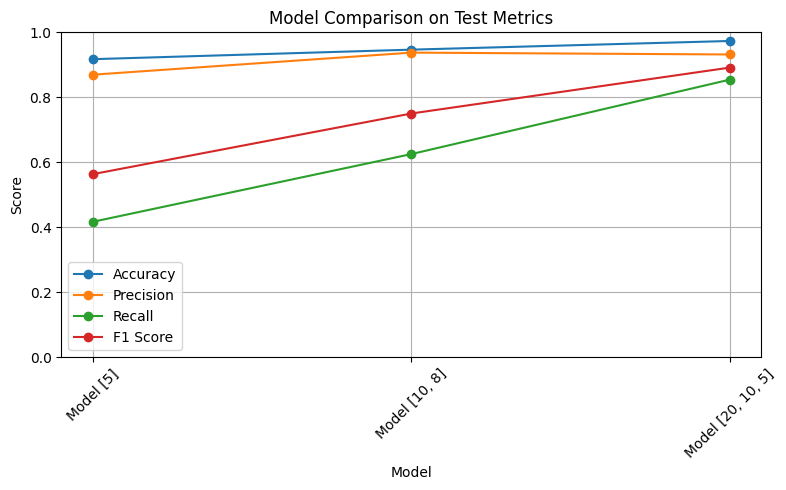

In [20]:
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 1️⃣ Reproducibility
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if GPU is available
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)


# 2️⃣ Load & Preprocess Data
df = pd.read_csv("input2.csv")
df['Rain'] = df['Rain'].apply(lambda x: 1 if x.lower() == 'rain' else 0)

X = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
y = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32).reshape(-1, 1)

# normalize features
X = (X - X.mean(0)) / X.std(0)

# split into train / val / test (70% / 15% / 15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")


# 3️⃣ Neural Network Definition
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, activation_fn=F.relu):
        super().__init__()
        self.activation_fn = activation_fn
        layers = []
        in_size = input_size

        # hidden layers
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            in_size = h

        # output layer
        layers.append(nn.Linear(in_size, 1))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_fn(layer(x))
        x = torch.sigmoid(self.layers[-1](x))
        return x


# 4️⃣ Training Function
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_losses, val_losses = [], []
    for epoch in range(1, epochs+1):
        model.train()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)
            val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} — Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


# 5️⃣ Evaluation Function
def evaluate(model, X_test, y_test, model_name):
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        preds_label = (preds >= 0.5).float()

    y_true = y_test.cpu().numpy()
    y_pred = preds_label.cpu().numpy()

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n--- {model_name} Evaluation ---")
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy:  {acc*100:.2f}%")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return acc, prec, rec, f1


# 6️⃣ Plotting Helpers
def plot_losses(train_losses, val_losses, title):
    plt.figure()
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Val Loss", marker='o')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_metrics(metrics):
    labels = list(metrics.keys())
    x = range(len(labels))

    acc = [metrics[m]['accuracy'][0] for m in labels]
    prec = [metrics[m]['precision'][0] for m in labels]
    rec = [metrics[m]['recall'][0] for m in labels]
    f1  = [metrics[m]['f1'][0] for m in labels]

    plt.figure(figsize=(8,5))
    plt.plot(x, acc,  label='Accuracy', marker='o')
    plt.plot(x, prec, label='Precision', marker='o')
    plt.plot(x, rec,  label='Recall',    marker='o')
    plt.plot(x, f1,   label='F1 Score',  marker='o')
    plt.xticks(x, labels, rotation=45)
    plt.title("Model Comparison on Test Metrics")
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 7️⃣ Run Experiments & Collect Metrics
metrics = {
    'Model 1 [5]':     {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'Model 2 [10,5]':  {'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'Model 3 [20,10,5]':{'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
}
# 1. Define your configs up front
hidden_layer_configs = [
    [5],
    [10, 8],
    [20, 10, 5]
]

# 2. Build an empty metrics dict whose keys are constructed from the cfg
metrics = {}
for cfg in hidden_layer_configs:
    name = f"Model {cfg}"
    metrics[name] = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

# 3. Loop over configs and use the same name
for cfg in hidden_layer_configs:
    name = f"Model {cfg}"
    print(f"\n### Training {name}")
    model = NeuralNet(X.shape[1], cfg)
    train_losses, val_losses = train_model(
        model, X_train, y_train, X_val, y_val,
        epochs=100, lr=0.01
    )
    acc, prec, rec, f1 = evaluate(model, X_test, y_test, name)

    metrics[name]['accuracy'].append(acc)
    metrics[name]['precision'].append(prec)
    metrics[name]['recall'].append(rec)
    metrics[name]['f1'].append(f1)

    plot_losses(train_losses, val_losses, f"{name} Loss Curve")

# 4. Plot
plot_metrics(metrics)
